# Modeling

---

This notebook outlines the process for creating the prediction model for predicting tax assessed property values for the Zillow dataset.

---

## Importing the Required Modules

Below we import all the modules needed to run this notebook.

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor
from sklearn.preprocessing import PolynomialFeatures

from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, RFE, f_regression, SequentialFeatureSelector
from sklearn.preprocessing import MinMaxScaler

from env import username, password, hostname

## Acquire and Split Data

Here we define all our acquisition and preparation functions created in the acquire and prepare notebook.

In [2]:
def get_db_url(database_name, username = username, password = password, hostname = hostname):
    return f'mysql+pymysql://{username}:{password}@{hostname}/{database_name}'

def get_zillow_sql():
    return """
        SELECT
            properties_2017.parcelid,
            bedroomcnt,
            bathroomcnt,
            calculatedfinishedsquarefeet,
            taxvaluedollarcnt,
            yearbuilt,
            fips,
            numberofstories,
            basementsqft,
            fireplacecnt,
            heatingorsystemdesc,
            airconditioningdesc,
            roomcnt,
            garagetotalsqft,
            hashottuborspa,
            poolcnt,
            poolsizesum,
            yardbuildingsqft17,
            buildingqualitytypeid,
            finishedfloor1squarefeet,
            finishedsquarefeet15,
            lotsizesquarefeet 
        FROM properties_2017
        JOIN propertylandusetype
            ON propertylandusetype.propertylandusetypeid = properties_2017.propertylandusetypeid
            AND (propertylandusetype.propertylandusedesc IN ('Single Family Residential', 'Inferred Single Family Residential'))
        LEFT JOIN heatingorsystemtype USING (heatingorsystemtypeid)
        LEFT JOIN airconditioningtype USING (airconditioningtypeid)
        JOIN predictions_2017 ON properties_2017.parcelid = predictions_2017.parcelid
        AND predictions_2017.transactiondate LIKE '2017%%';
        """

def get_zillow_data(use_cache = True):
    # If the file is cached, read from the .csv file
    if os.path.exists('zillow.csv') and use_cache:
        print('Using cache')
        return pd.read_csv('zillow.csv')
    
    # Otherwise read from the mysql database
    else:
        print('Reading from database')
        df = pd.read_sql(get_zillow_sql(), get_db_url('zillow'))
        df.to_csv('zillow.csv', index = False)
        return df
    
def prepare_zillow_data(df: pd.core.frame.DataFrame) -> pd.core.frame.DataFrame:
    '''
        Returns a prepared zillow dataset with all missing values handled.
        
        Parameters
        ----------
        df: DataFrame
            A pandas dataframe containing the unprepared zillow dataset.
        
        Returns
        -------
        DataFrame: A pandas dataframe containing the prepared zillow dataset.
    '''
    
    missing_target = df.taxvaluedollarcnt.isnull()
    df = df[~missing_target]
    
    avg_square_feet = df.calculatedfinishedsquarefeet.mean()
    df.calculatedfinishedsquarefeet.fillna(avg_square_feet, inplace = True)
    
    df.yearbuilt.fillna(df.yearbuilt.mode()[0], inplace = True)
    df.fireplacecnt.fillna(0, inplace = True)
    df.hashottuborspa.fillna(0, inplace = True)
    df.poolcnt.fillna(0, inplace = True)
    
    median_quality = df.buildingqualitytypeid.median()
    df.buildingqualitytypeid.fillna(median_quality, inplace = True)
    
    median_lotsize = df.lotsizesquarefeet.median()
    df.lotsizesquarefeet.fillna(median_lotsize, inplace = True)
    
    df = df.drop(columns = 'parcelid')
    df = df.drop(columns = 'numberofstories')
    df = df.drop(columns = 'basementsqft')
    df = df.drop(columns = 'heatingorsystemdesc')
    df = df.drop(columns = 'airconditioningdesc')
    df = df.drop(columns = 'garagetotalsqft')
    df = df.drop(columns = 'poolsizesum')
    df = df.drop(columns = 'yardbuildingsqft17')
    df = df.drop(columns = 'roomcnt')
    df = df.drop(columns = 'finishedfloor1squarefeet')
    df = df.drop(columns = 'finishedsquarefeet15')
    df = df.drop(columns = 'lotsizesquarefeet')
    
    df.bedroomcnt = df.bedroomcnt.astype('int')
    df.fireplacecnt = df.fireplacecnt.astype('int')
    df.hashottuborspa = df.hashottuborspa.astype('int')
    df.poolcnt = df.poolcnt.astype('int')
    
    df.fips = df.fips.astype('int')
    df.fips = df.fips.astype('object')
    df = pd.get_dummies(df, columns = ['fips'])
    
    df['property_age'] = 2017 - df.yearbuilt
    df = df.drop(columns = 'yearbuilt')
    
    df['amenities'] = df.hashottuborspa + df.poolcnt + df.fireplacecnt
    df = df.drop(columns = 'hashottuborspa')
    df = df.drop(columns = 'poolcnt')
    df = df.drop(columns = 'fireplacecnt')

    # Rename the columns for readability
    df = df.rename(columns = {
        'bedroomcnt' : 'bedroom_count',
        'bathroomcnt' : 'bathroom_count',
        'calculatedfinishedsquarefeet' : 'square_feet',
        'taxvaluedollarcnt' : 'property_tax_assessed_values',
        'buildingqualitytypeid' : 'building_quality',
        'fips_6037' : 'fed_code_6037',
        'fips_6059' : 'fed_code_6059',
        'fips_6111' : 'fed_code_6111'
    })
    
    return df

def remove_outliers(df, k, col_list):
    for col in col_list:

        q1, q3 = df[col].quantile([.25, .75])  # get quartiles
        
        iqr = q3 - q1   # calculate interquartile range
        
        upper_bound = q3 + k * iqr   # get upper bound
        lower_bound = q1 - k * iqr   # get lower bound

        # return dataframe without outliers
        
        df = df[(df[col] > lower_bound) & (df[col] < upper_bound)]
        
    return df

In [3]:
def split_data(df, random_seed = 24, stratify = None):
    test_split = 0.2
    train_validate_split = 0.3

    train_validate, test = train_test_split(
        df,
        test_size = test_split,
        random_state = random_seed,
        stratify = stratify if not stratify else df[stratify]
    )
    train, validate = train_test_split(
        train_validate,
        test_size = train_validate_split,
        random_state = random_seed,
        stratify = stratify if not stratify else train_validate[stratify]
    )
    return train, validate, test

def scale_data(train, validate, test, columns):
    scaler = MinMaxScaler()
    
    train[columns] = scaler.fit_transform(train[columns])
    validate[columns] = scaler.transform(validate[columns])
    test[columns] = scaler.transform(test[columns])
    
    return train, validate, test

Now we can acquire, prepare, and split our data.

In [4]:
train, validate, test = split_data(prepare_zillow_data(get_zillow_data()))

# We'll scale everything except the target variable to ensure that the model does not have any unexpected bias.
train, validate, test = scale_data(train, validate, test, train.drop(columns = 'property_tax_assessed_values').columns)
train.shape, validate.shape, test.shape

Using cache


/usr/local/anaconda3/lib/python3.9/site-packages/pandas/core/generic.py:6392: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return self._update_inplace(result)


((29366, 10), (12586, 10), (10488, 10))

In [5]:
# We'll remove outliers so that they don't skew the results of our model
train = remove_outliers(train, 1.5, ['property_tax_assessed_values', 'bedroom_count', 'bathroom_count'])
train.shape

(26236, 10)

Now we will split our datasets each into two sets, one with all our features, another with only the target variable.

In [6]:
X_train, y_train = train.drop(columns = 'property_tax_assessed_values'), train.property_tax_assessed_values
X_validate, y_validate = validate.drop(columns = 'property_tax_assessed_values'), validate.property_tax_assessed_values
X_test, y_test = test.drop(columns = 'property_tax_assessed_values'), test.property_tax_assessed_values

## Create a Baseline

Before we can begin building some models we must establish a baseline. We will create two (one using the median of the target, the other using the mean of the target) and we'll choose the best as our baseline.

In [7]:
baseline = pd.DataFrame({
    'median' : [y_train.median()] * y_train.size,
    'mean' : [y_train.mean()] * y_train.size
})
baseline.shape

(26236, 2)

In [8]:
print(f'RMSE median baseline: {mean_squared_error(y_train, baseline["median"], squared = False)}')
print(f'RMSE mean baseline: {mean_squared_error(y_train, baseline["mean"], squared = False)}')

RMSE median baseline: 266034.95842401474
RMSE mean baseline: 262391.84622251


We'll use the mean as our baseline.

## Feature Selection

Now we will use the RFE algorithm to rank our features in terms of relevance in predicting the target variable. We will use this later when trying different features in our models. This can also help in making our recommendation later on. We will not include the locations in this model since we will later try to build different models for each county.

In [9]:
features = [
    'square_feet',
    'bedroom_count',
    'bathroom_count',
    'property_age',
    'amenities',
    'building_quality'
]

lm = LinearRegression()

rfe = RFE(lm, n_features_to_select = 3)
rfe.fit(X_train[features], y_train)

RFE(estimator=LinearRegression(), n_features_to_select=3)

In [10]:
pd.DataFrame({'rfe_ranking': rfe.ranking_}, index=X_train[features].columns)

,rfe_ranking
square_feet,1
bedroom_count,1
bathroom_count,1
property_age,4
amenities,2
building_quality,3


Not surprisingly the square_feet, bedroom_count, and bathroom_count features have the highest rankings, but now we know that the other features are ordered as amenities, building_quality, and property_age in regards to importance in our problem. This can help us later on.

## Creating the Models

We'll keep all of our results in a dictionary for easy viewing.

In [11]:
baseline_val = pd.Series([y_train.mean()] * y_validate.size)

results = {
    'baseline' : {
        'RMSE' : mean_squared_error(y_train, baseline['mean'], squared = False),
        'R^2' : r2_score(y_train, baseline['mean']),
        'RMSE_val' : mean_squared_error(y_validate, baseline_val, squared = False),
        'R^2_val' : r2_score(y_validate, baseline_val)
    }
}

feature_set_1 = [
    'square_feet',
    'bedroom_count',
    'bathroom_count'
]

### Target Distribution

Let's see our target distribution to help us decide which algorithm may be best for our problem.

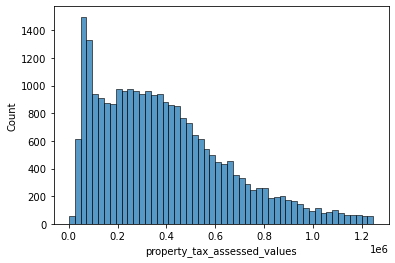

In [12]:
sns.histplot(y_train);

The distribution is not necessarily normal. We'll try linear regression, polynomial regression, polynomial regression with interactions only, and a tweedie regressor since this one may work best for this distribution.

### Square Feet, Bedroom Count, and Bathroom Count

As per the project requirements the first pass of modeling will only use the square_feet, bedroom_count, and bathroom_count features. After we'll try using different features depending on which algorithm gives us the best model.

#### Linear Regression

We'll start with a linear regression model.

In [13]:
model = LinearRegression()
model.fit(X_train[feature_set_1], y_train)

r2_score(y_train, model.predict(X_train[feature_set_1]))

0.24191751154448216

In [14]:
mean_squared_error(y_train, model.predict(X_train[feature_set_1]), squared = False)

228459.1557764831

In [15]:
results['linear_regression'] = {
    'RMSE' : mean_squared_error(y_train, model.predict(X_train[feature_set_1]), squared = False),
    'R^2' : r2_score(y_train, model.predict(X_train[feature_set_1])),
    'RMSE_val' : mean_squared_error(y_validate, model.predict(X_validate[feature_set_1]), squared = False),
    'R^2_val' : r2_score(y_validate, model.predict(X_validate[feature_set_1]))
}

#### Polynomial Regression

Next we'll try a polynomial regression model.

In [16]:
poly = PolynomialFeatures(degree = 2, include_bias = False, interaction_only = False)
poly.fit(X_train[feature_set_1])

X_train_poly = pd.DataFrame(
    poly.transform(X_train[feature_set_1]),
    columns = poly.get_feature_names(X_train[feature_set_1].columns),
    index = X_train[feature_set_1].index
)

model = LinearRegression()
model.fit(X_train_poly, y_train)

r2_score(y_train, model.predict(X_train_poly))

0.24387184724343092

In [17]:
mean_squared_error(y_train, model.predict(X_train_poly), squared = False)

228164.48202908624

Before we make predictions on validate we need to prepare the X_validate set with the polynomial features.

In [18]:
poly = PolynomialFeatures(degree = 2, include_bias = False, interaction_only = False)
poly.fit(X_validate[feature_set_1])

X_validate_poly = pd.DataFrame(
    poly.transform(X_validate[feature_set_1]),
    columns = poly.get_feature_names(X_validate[feature_set_1].columns),
    index = X_validate[feature_set_1].index
)

In [19]:
results['polynomial_regression'] = {
    'RMSE' : mean_squared_error(y_train, model.predict(X_train_poly), squared = False),
    'R^2' : r2_score(y_train, model.predict(X_train_poly)),
    'RMSE_val' : mean_squared_error(y_validate, model.predict(X_validate_poly), squared = False),
    'R^2_val' : r2_score(y_validate, model.predict(X_validate_poly))
}

#### Polynomial Regression Interactions Only

Now let's try polynomial regression with interactions only.

In [20]:
poly = PolynomialFeatures(degree = 2, include_bias = False, interaction_only = True)
poly.fit(X_train[feature_set_1])

X_train_poly = pd.DataFrame(
    poly.transform(X_train[feature_set_1]),
    columns = poly.get_feature_names(X_train[feature_set_1].columns),
    index = X_train[feature_set_1].index
)

model = LinearRegression()
model.fit(X_train_poly, y_train)

r2_score(y_train, model.predict(X_train_poly))

0.24224844372732957

In [21]:
mean_squared_error(y_train, model.predict(X_train_poly), squared = False)

228409.28472608118

In [22]:
# We have to prepare the validate set again

poly = PolynomialFeatures(degree = 2, include_bias = False, interaction_only = True)
poly.fit(X_validate[feature_set_1])

X_validate_poly = pd.DataFrame(
    poly.transform(X_validate[feature_set_1]),
    columns = poly.get_feature_names(X_validate[feature_set_1].columns),
    index = X_validate[feature_set_1].index
)

In [23]:
results['polynomial_regression_interactions_only'] = {
    'RMSE' : mean_squared_error(y_train, model.predict(X_train_poly), squared = False),
    'R^2' : r2_score(y_train, model.predict(X_train_poly)),
    'RMSE_val' : mean_squared_error(y_validate, model.predict(X_validate_poly), squared = False),
    'R^2_val' : r2_score(y_validate, model.predict(X_validate_poly))
}

#### Tweedie Regressor

Finally, let's try the tweedie regressor with power set to 0 since we'll assume a normal distribution.

In [24]:
model = TweedieRegressor(power = 0, alpha = 0)
model.fit(X_train[feature_set_1], y_train)

r2_score(y_train, model.predict(X_train[feature_set_1]))

0.24191751154448216

In [25]:
mean_squared_error(y_train, model.predict(X_train[feature_set_1]), squared = False)

228459.1557764831

In [26]:
results['tweedie_regressor'] = {
    'RMSE' : mean_squared_error(y_train, model.predict(X_train[feature_set_1]), squared = False),
    'R^2' : r2_score(y_train, model.predict(X_train[feature_set_1])),
    'RMSE_val' : mean_squared_error(y_validate, model.predict(X_validate[feature_set_1]), squared = False),
    'R^2_val' : r2_score(y_validate, model.predict(X_validate[feature_set_1]))
}

#### Results

Now let's see the results of our first pass at modeling.

In [27]:
pd.DataFrame(results).T

,RMSE,R^2,RMSE_val,R^2_val
baseline,262391.846223,0.000000,674331.770521,-0.046451
linear_regression,228459.155776,0.241918,571651.969436,0.247970
polynomial_regression,228164.482029,0.243872,569616.052898,0.253317
polynomial_regression_interactions_only,228409.284726,0.242248,564340.381027,0.267084
tweedie_regressor,228459.155776,0.241918,571651.969536,0.247970


All the models have similar performance. We'll move forward with polynomial regression since has the best performance on train and remains consistent on validate.

### Trying Different Features

Now let's try introducing other features into our polynomial regression model.

#### Amenities

Let's introduce the amenities feature into our model.

In [28]:
feature_set_2 = [
    'square_feet',
    'bedroom_count',
    'bathroom_count',
    'amenities'
]

In [29]:
poly = PolynomialFeatures(degree = 2, include_bias = False, interaction_only = False)
poly.fit(X_train[feature_set_2])

X_train_poly = pd.DataFrame(
    poly.transform(X_train[feature_set_2]),
    columns = poly.get_feature_names(X_train[feature_set_2].columns),
    index = X_train[feature_set_2].index
)

model = LinearRegression()
model.fit(X_train_poly, y_train)

r2_score(y_train, model.predict(X_train_poly))

0.2507222971149823

In [30]:
mean_squared_error(y_train, model.predict(X_train_poly), squared = False)

227128.55598003216

In [31]:
# We have to prepare the validate set again

poly = PolynomialFeatures(degree = 2, include_bias = False, interaction_only = False)
poly.fit(X_validate[feature_set_2])

X_validate_poly = pd.DataFrame(
    poly.transform(X_validate[feature_set_2]),
    columns = poly.get_feature_names(X_validate[feature_set_2].columns),
    index = X_validate[feature_set_2].index
)

In [32]:
results['poly_regression_with_amenities'] = {
    'RMSE' : mean_squared_error(y_train, model.predict(X_train_poly), squared = False),
    'R^2' : r2_score(y_train, model.predict(X_train_poly)),
    'RMSE_val' : mean_squared_error(y_validate, model.predict(X_validate_poly), squared = False),
    'R^2_val' : r2_score(y_validate, model.predict(X_validate_poly))
}

#### Building Quality

Next let's introduce building quality into the model.

In [33]:
feature_set_3 = [
    'square_feet',
    'bedroom_count',
    'bathroom_count',
    'building_quality'
]

In [34]:
poly = PolynomialFeatures(degree = 2, include_bias = False, interaction_only = False)
poly.fit(X_train[feature_set_3])

X_train_poly = pd.DataFrame(
    poly.transform(X_train[feature_set_3]),
    columns = poly.get_feature_names(X_train[feature_set_3].columns),
    index = X_train[feature_set_3].index
)

model = LinearRegression()
model.fit(X_train_poly, y_train)

r2_score(y_train, model.predict(X_train_poly))

0.24780418454540953

In [35]:
mean_squared_error(y_train, model.predict(X_train_poly), squared = False)

227570.40993368268

In [36]:
# We have to prepare the validate set again

poly = PolynomialFeatures(degree = 2, include_bias = False, interaction_only = False)
poly.fit(X_validate[feature_set_3])

X_validate_poly = pd.DataFrame(
    poly.transform(X_validate[feature_set_3]),
    columns = poly.get_feature_names(X_validate[feature_set_3].columns),
    index = X_validate[feature_set_3].index
)

In [37]:
results['poly_regression_with_building_quality'] = {
    'RMSE' : mean_squared_error(y_train, model.predict(X_train_poly), squared = False),
    'R^2' : r2_score(y_train, model.predict(X_train_poly)),
    'RMSE_val' : mean_squared_error(y_validate, model.predict(X_validate_poly), squared = False),
    'R^2_val' : r2_score(y_validate, model.predict(X_validate_poly))
}

#### Property Age

Now we'll try property age.

In [38]:
feature_set_4 = [
    'square_feet',
    'bedroom_count',
    'bathroom_count',
    'property_age'
]

In [39]:
poly = PolynomialFeatures(degree = 2, include_bias = False, interaction_only = False)
poly.fit(X_train[feature_set_4])

X_train_poly = pd.DataFrame(
    poly.transform(X_train[feature_set_4]),
    columns = poly.get_feature_names(X_train[feature_set_4].columns),
    index = X_train[feature_set_4].index
)

model = LinearRegression()
model.fit(X_train_poly, y_train)

r2_score(y_train, model.predict(X_train_poly))

0.24920769598729364

In [40]:
mean_squared_error(y_train, model.predict(X_train_poly), squared = False)

227358.00061375354

In [41]:
# We have to prepare the validate set again

poly = PolynomialFeatures(degree = 2, include_bias = False, interaction_only = False)
poly.fit(X_validate[feature_set_4])

X_validate_poly = pd.DataFrame(
    poly.transform(X_validate[feature_set_4]),
    columns = poly.get_feature_names(X_validate[feature_set_4].columns),
    index = X_validate[feature_set_4].index
)

In [42]:
results['poly_regression_with_property_age'] = {
    'RMSE' : mean_squared_error(y_train, model.predict(X_train_poly), squared = False),
    'R^2' : r2_score(y_train, model.predict(X_train_poly)),
    'RMSE_val' : mean_squared_error(y_validate, model.predict(X_validate_poly), squared = False),
    'R^2_val' : r2_score(y_validate, model.predict(X_validate_poly))
}

#### All Features

Finally, let's try a model with all features.

In [43]:
feature_set_5 = [
    'square_feet',
    'bedroom_count',
    'bathroom_count',
    'amenities',
    'building_quality',
    'property_age'
]

In [44]:
poly = PolynomialFeatures(degree = 2, include_bias = False, interaction_only = False)
poly.fit(X_train[feature_set_5])

X_train_poly = pd.DataFrame(
    poly.transform(X_train[feature_set_5]),
    columns = poly.get_feature_names(X_train[feature_set_5].columns),
    index = X_train[feature_set_5].index
)

model = LinearRegression()
model.fit(X_train_poly, y_train)

r2_score(y_train, model.predict(X_train_poly))

0.27418273142647764

In [45]:
mean_squared_error(y_train, model.predict(X_train_poly), squared = False)

223544.49717234555

In [46]:
# We have to prepare the validate set again

poly = PolynomialFeatures(degree = 2, include_bias = False, interaction_only = False)
poly.fit(X_validate[feature_set_5])

X_validate_poly = pd.DataFrame(
    poly.transform(X_validate[feature_set_5]),
    columns = poly.get_feature_names(X_validate[feature_set_5].columns),
    index = X_validate[feature_set_5].index
)

In [47]:
results['poly_regression_all_features'] = {
    'RMSE' : mean_squared_error(y_train, model.predict(X_train_poly), squared = False),
    'R^2' : r2_score(y_train, model.predict(X_train_poly)),
    'RMSE_val' : mean_squared_error(y_validate, model.predict(X_validate_poly), squared = False),
    'R^2_val' : r2_score(y_validate, model.predict(X_validate_poly))
}

#### Results

Let's see the final results.

In [48]:
pd.DataFrame(results).T

,RMSE,R^2,RMSE_val,R^2_val
baseline,262391.846223,0.000000,674331.770521,-0.046451
linear_regression,228459.155776,0.241918,571651.969436,0.247970
polynomial_regression,228164.482029,0.243872,569616.052898,0.253317
polynomial_regression_interactions_only,228409.284726,0.242248,564340.381027,0.267084
tweedie_regressor,228459.155776,0.241918,571651.969536,0.247970
poly_regression_with_amenities,227128.555980,0.250722,568498.322933,0.256245
poly_regression_with_building_quality,227570.409934,0.247804,567458.104506,0.258964
poly_regression_with_property_age,227358.000614,0.249208,579600.948824,0.226910
poly_regression_all_features,223544.497172,0.274183,576981.836722,0.233881


Adding total amenities to the model improved the performance and it remains consistent with the validate set.

### Trying a Different Model For Each County

Now we'll try separating the data by county and see if this helps improve model performance.

In [49]:
los_angeles_county = lambda df: df.fed_code_6037 == 1
orange_county = lambda df: df.fed_code_6059 == 1
ventura_county = lambda df: df.fed_code_6111 == 1

In [50]:
# train[los_angeles_county(train)].info()

#### Los Angeles County

Let's try building our model using only properties in Los Angeles County.

In [51]:
# We will use feature_set_2 since this set of features includes only the amenities feature

X_train_6037 = train[los_angeles_county(train)][feature_set_2]
y_train_6037 = train[los_angeles_county(train)].property_tax_assessed_values

poly = PolynomialFeatures(degree = 2, include_bias = False, interaction_only = False)
poly.fit(X_train_6037)

X_train_poly = pd.DataFrame(
    poly.transform(X_train_6037),
    columns = poly.get_feature_names(X_train_6037.columns),
    index = X_train_6037.index
)

model = LinearRegression()
model.fit(X_train_poly, y_train_6037)

r2_score(y_train_6037, model.predict(X_train_poly))

0.1929838032528538

In [52]:
mean_squared_error(y_train_6037, model.predict(X_train_poly), squared = False)

230173.11449982203

In [53]:
# We have to prepare the validate set again

X_validate_6037 = validate[los_angeles_county(validate)][feature_set_2]
y_validate_6037 = validate[los_angeles_county(validate)].property_tax_assessed_values

poly = PolynomialFeatures(degree = 2, include_bias = False, interaction_only = False)
poly.fit(X_validate_6037)

X_validate_poly = pd.DataFrame(
    poly.transform(X_validate_6037),
    columns = poly.get_feature_names(X_validate_6037.columns),
    index = X_validate_6037.index
)

In [54]:
results['los_angeles_county_only'] = {
    'RMSE' : mean_squared_error(y_train_6037, model.predict(X_train_poly), squared = False),
    'R^2' : r2_score(y_train_6037, model.predict(X_train_poly)),
    'RMSE_val' : mean_squared_error(y_validate_6037, model.predict(X_validate_poly), squared = False),
    'R^2_val' : r2_score(y_validate_6037, model.predict(X_validate_poly))
}

#### Orange County

Now let's try the model only with properties in Orange County.

In [55]:
# We will use feature_set_2 since this set of features includes only the amenities feature

X_train_6059 = train[orange_county(train)][feature_set_2]
y_train_6059 = train[orange_county(train)].property_tax_assessed_values

poly = PolynomialFeatures(degree = 2, include_bias = False, interaction_only = False)
poly.fit(X_train_6059)

X_train_poly = pd.DataFrame(
    poly.transform(X_train_6059),
    columns = poly.get_feature_names(X_train_6059.columns),
    index = X_train_6059.index
)

model = LinearRegression()
model.fit(X_train_poly, y_train_6059)

r2_score(y_train_6059, model.predict(X_train_poly))

0.308029281065225

In [56]:
mean_squared_error(y_train_6059, model.predict(X_train_poly), squared = False)

223687.578631957

In [57]:
# We have to prepare the validate set again

X_validate_6059 = validate[orange_county(validate)][feature_set_2]
y_validate_6059 = validate[orange_county(validate)].property_tax_assessed_values

poly = PolynomialFeatures(degree = 2, include_bias = False, interaction_only = False)
poly.fit(X_validate_6059)

X_validate_poly = pd.DataFrame(
    poly.transform(X_validate_6059),
    columns = poly.get_feature_names(X_validate_6059.columns),
    index = X_validate_6059.index
)

In [58]:
results['orange_county_only'] = {
    'RMSE' : mean_squared_error(y_train_6059, model.predict(X_train_poly), squared = False),
    'R^2' : r2_score(y_train_6059, model.predict(X_train_poly)),
    'RMSE_val' : mean_squared_error(y_validate_6059, model.predict(X_validate_poly), squared = False),
    'R^2_val' : r2_score(y_validate_6059, model.predict(X_validate_poly))
}

#### Ventura County

Finally, let's try our model with only properties in Ventura County.

In [59]:
# We will use feature_set_2 since this set of features includes only the amenities feature

X_train_6111 = train[ventura_county(train)][feature_set_2]
y_train_6111 = train[ventura_county(train)].property_tax_assessed_values

poly = PolynomialFeatures(degree = 2, include_bias = False, interaction_only = False)
poly.fit(X_train_6111)

X_train_poly = pd.DataFrame(
    poly.transform(X_train_6111),
    columns = poly.get_feature_names(X_train_6111.columns),
    index = X_train_6111.index
)

model = LinearRegression()
model.fit(X_train_poly, y_train_6111)

r2_score(y_train_6111, model.predict(X_train_poly))

0.40694418717169123

In [60]:
mean_squared_error(y_train_6111, model.predict(X_train_poly), squared = False)

184570.66937237233

In [61]:
# We have to prepare the validate set again

X_validate_6111 = validate[ventura_county(validate)][feature_set_2]
y_validate_6111 = validate[ventura_county(validate)].property_tax_assessed_values

poly = PolynomialFeatures(degree = 2, include_bias = False, interaction_only = False)
poly.fit(X_validate_6111)

X_validate_poly = pd.DataFrame(
    poly.transform(X_validate_6111),
    columns = poly.get_feature_names(X_validate_6111.columns),
    index = X_validate_6111.index
)

In [62]:
results['ventura_county_only'] = {
    'RMSE' : mean_squared_error(y_train_6111, model.predict(X_train_poly), squared = False),
    'R^2' : r2_score(y_train_6111, model.predict(X_train_poly)),
    'RMSE_val' : mean_squared_error(y_validate_6111, model.predict(X_validate_poly), squared = False),
    'R^2_val' : r2_score(y_validate_6111, model.predict(X_validate_poly))
}

In [63]:
# import evaluate

In [64]:
# evaluate.plot_residuals(y_validate_6111, model.predict(X_validate_poly))

#### Results

Now let's see the results.

In [65]:
pd.DataFrame(results).T

,RMSE,R^2,RMSE_val,R^2_val
baseline,262391.846223,0.000000,674331.770521,-0.046451
linear_regression,228459.155776,0.241918,571651.969436,0.247970
polynomial_regression,228164.482029,0.243872,569616.052898,0.253317
polynomial_regression_interactions_only,228409.284726,0.242248,564340.381027,0.267084
tweedie_regressor,228459.155776,0.241918,571651.969536,0.247970
poly_regression_with_amenities,227128.555980,0.250722,568498.322933,0.256245
poly_regression_with_building_quality,227570.409934,0.247804,567458.104506,0.258964
poly_regression_with_property_age,227358.000614,0.249208,579600.948824,0.226910
poly_regression_all_features,223544.497172,0.274183,576981.836722,0.233881
los_angeles_county_only,230173.114500,0.192984,623628.678549,0.207006


We can see that the performance of our model increases significantly when predicting property value in Orange and Ventura counties. For Los Angeles County the performance does decrease (which is unfortunate since this county makes up the bulk of our data), but it does remain consistent on the validate set.

---

## Conclusions

When we add total amenities to the set of features (square_feet, bedroom_count, and bathroom_count) the performance of our polynomial regression model improves. Furthermore, when creating different models for each county we see improved performance for Orange and Ventura counties while the performance for Los Angeles county at least remains consistent on unseen data.